# Linear models for regression

Linear models for regression have been studied in statistics long before the advent of computers, but they still have their place today and in some cases even give better results than more complex models (especially if we have many attributes but only few instances). Their other advantage is the simple interpretability of the model; the coefficients of a linear model can easily be used to see how the variables affect the outcome. 

We start with regression models. So, we have data $\{(x_i, y_i), 1 \leq i \leq N\}$, where $x_i = (x_1, \dots, x_p)$ and we will look for the coefficients of $\beta_i$ so that the model $\hat{y}_i = \beta_0 + \sum_{i=1}^p \beta_i x_i$ fits the data as well as possible, i.e. we will minimize $$\mathrm{RSS}=\sum_{i=1}^N(y_i-\hat{y}_i)^2.$$

## Ordinary Least Squares (OLS) + statistical tests

The simplest way to estimate the parameters $\beta_i$ is the OLS method. To simplify the notation, we will consider a matrix $X$ that contains the vectors $(1:x_i)$ on the rows, i.e. $x_i$ is prefixed with a one (for the coefficient $\beta_0$). The RSS can then be written as $$\mathrm{RSS}(\beta)=\sum_{i=1}^N(y_i-X\beta)^T(y_i-X\beta). $$ We can then derive the RSS with respect to $\beta$ and get $$\frac{\partial \mathrm{RSS}}{\partial \beta} = -2X^T(y-X\beta).$$ We are looking for the minimum, so we set this derivative equal to 0 and get the solution $$\hat{\beta}=(X^TX)^{-1}X^Ty.$$

Interestingly, we can also compute the confidential itervals for each $\beta_i$, and we can also test if any particular $\beta_i=0$. This is useful for interpreting the results, and also for removing variables for which the coefficient is zero from the model (since they probably do not add anything to the model). Assuming that the observations $y_i$ are uncorrelated and have variance $\sigma$, the variances of the estimates $$Var(\hat{\beta}_i) = (X^TX)^{-1}\hat{\sigma}^2, $$ $\sigma^2$ is typically computed as $$\hat{\sigma}^2=\frac{1}{N-p-1}\sum_{i=1}^N(y_i-\hat{y}_i)^2. $$ With the addition of further assumptions, we get that $$\beta \sim N(\beta, (X^TX)^{-1}\sigma^2).$$

To test the hypothesis that $\beta_i=0$, we can compute the so-called $Z$-score $$z_i=\frac{\hat{\beta}_i}{\hat{\sigma}\sqrt{v_i}},$$ where $v_i$ is the $i$-th element on the diagonal of the matrix $(X^TX)^{-1}$. Under the null hypothesis that $\beta_i=0$, $z_i$ has a t-distribution with $N-p-1$ degrees of freedom and hence large values of $z_i$ will lead to rejecting the hypothesis that that $\beta_i=0$.

We may also be interested in what happens if we remove some variables from the model - will it still be as good? Again, we even have a statistical test for that in linear models. To test the significance of a whole group of variables, we use the so-called $F$ statistic $$F = \frac{(\mathrm{RSS}_0-\mathrm{RSS}_1)/(p_1-p_0)}{\mathrm{RSS}_1/(N-p_1-1)},$$ where $\mathrm{RSS}_i$ is the RSS of model $i$ and $p_i$ is the number of variables in model $i$. The $F$-statistic has a $F_{p_1-p_0,N-p_1-1}$ distribution.

We will not fit the linear models to some data and demonstrate what we said above in a few examples.

In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as fml
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# nacteme data a zobrazime jejich popis
data = sm.datasets.get_rdataset('Boston', 'MASS')
print(data.__doc__)

.. container::

   .. container::

      ====== ===============
      Boston R Documentation
      ====== ===============

      .. rubric:: Housing Values in Suburbs of Boston
         :name: housing-values-in-suburbs-of-boston

      .. rubric:: Description
         :name: description

      The ``Boston`` data frame has 506 rows and 14 columns.

      .. rubric:: Usage
         :name: usage

      .. code:: R

         Boston

      .. rubric:: Format
         :name: format

      This data frame contains the following columns:

      ``crim``
         per capita crime rate by town.

      ``zn``
         proportion of residential land zoned for lots over 25,000
         sq.ft.

      ``indus``
         proportion of non-retail business acres per town.

      ``chas``
         Charles River dummy variable (= 1 if tract bounds river; 0
         otherwise).

      ``nox``
         nitrogen oxides concentration (parts per 10 million).

      ``rm``
         average number of rooms per 

Let's first train the model on all the data and see the effect of the variables on the prices of the houses in Boston.

In [2]:
all_vars = 'crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+black+lstat'

#let's build a model using all the variables and print its description
m1 = fml.ols(formula='medv ~ %s'%all_vars, data=data.data)
res1 = m1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 11 Nov 2024   Prob (F-statistic):          6.72e-135
Time:                        16:34:27   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.4595      5.103      7.144      0.0

We see that, for example, an increase in crime rate by one reduces the value of houses by about 100\\$ (with the 95-% confidence interval being 43-173\\\$). We can also note that the variables `indus` and `age` probably do not affect the price, because their confidence intervals contain zero (and even the p-value of the t-test is high). So let's see if the model without these two variables will still be as good as the original one.

In [3]:
print(res1.f_test('indus = age = 0'))

<F test: F=0.05727398321766184, p=0.9443415971005645, df_denom=492, df_num=2>


It's not surprising that the p-value of the test came out high and so there's no evidence that the smaller model is worse. Let's try to train our smaller model now and look at it a little bit closer.

In [4]:
%matplotlib inline
m2_vars = 'crim+zn+chas+nox+rm+dis+rad+tax+ptratio+black+lstat'

m2 = fml.ols(formula='medv ~ %s'%m2_vars, data=data.data)
res2 = m2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     128.2
Date:                Mon, 11 Nov 2024   Prob (F-statistic):          5.54e-137
Time:                        16:34:32   Log-Likelihood:                -1498.9
No. Observations:                 506   AIC:                             3022.
Df Residuals:                     494   BIC:                             3072.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.3411      5.067      7.171      0.0

The linear regression assumes that there may be Gaussian noise in the data, so a good model should have residuals that are equal to that noise and are therefore distributed normally, we can look at the histogram of the residuals and check whether that is true or not.

We can also use the so called qqplot instead of the histogram. It shows the distribution of the residuals a bit better. The qqplot shows the quantiles of the normal distribution compared to the quantiles of the residuals. Ideally, the points in qqplot should lie in a single line with a 45° slope.

Also, the variance of residuals should not depend on the value of the predicted quantity, this can be easily plotted in the scatterplot. Of course, the residuals should also be distributed evenly around zero.

Finally, we plot the actual values vs. the predicted values, the graph should again ideally have all the points on the line with a 45° slope.

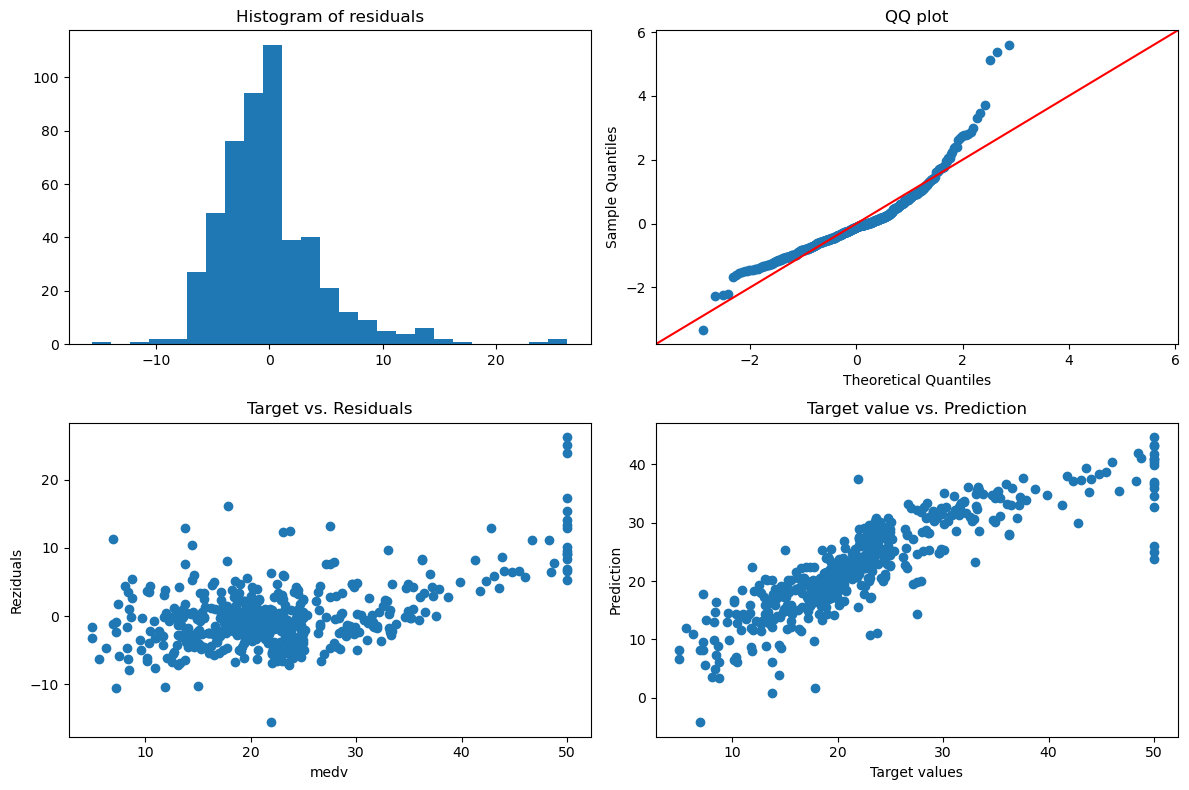

In [5]:
def plot_model_evaluation(res, targets):
    fig = plt.figure(figsize=(12,8))
    
    # histogram rezidui
    ax = plt.subplot(2,2,1)
    ax.hist(res.resid, bins=25)
    ax.set_title('Histogram of residuals')

    # QQ plot
    ax = plt.subplot(2,2,2)
    _ = sm.qqplot(res.resid, line='45', fit=True, ax=ax)
    ax.set_title('QQ plot')

    # zobrazeni hodnoty vs. chyby (ukazuje, jestli je rozptyl rezidui nezavisly na hodnote)
    ax = plt.subplot(2,2,3)
    ax.scatter(targets, res.resid)
    ax.set_title('Target vs. Residuals')
    ax.set_xlabel('medv')
    ax.set_ylabel('Reziduals')

    # zobrazeni predpovedi proti hodnote
    ax = plt.subplot(2,2,4)
    ax.scatter(targets, res.fittedvalues)
    ax.set_title('Target value vs. Prediction')
    ax.set_xlabel('Target values')
    ax.set_ylabel('Prediction')

    plt.tight_layout()
    plt.show()
    
plot_model_evaluation(res2, data.data['medv'])

We see that our model doesn't quite meet the requirements of a good model (but that doesn't mean that we can't use it successfully). Let's try to tweak it a little bit. We see that the residues are larger the larger the actual value, plus we predict a price that can have a relatively large range. In such cases, it may be useful to predict the logarithm of the price instead of the price. Let's see what our model does when we tweak it this way.

                            OLS Regression Results                            
Dep. Variable:           np.log(medv)   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     168.1
Date:                Mon, 11 Nov 2024   Prob (F-statistic):          4.31e-159
Time:                        16:34:50   Log-Likelihood:                 129.02
No. Observations:                 506   AIC:                            -234.0
Df Residuals:                     494   BIC:                            -183.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0837      0.203     20.112      0.0

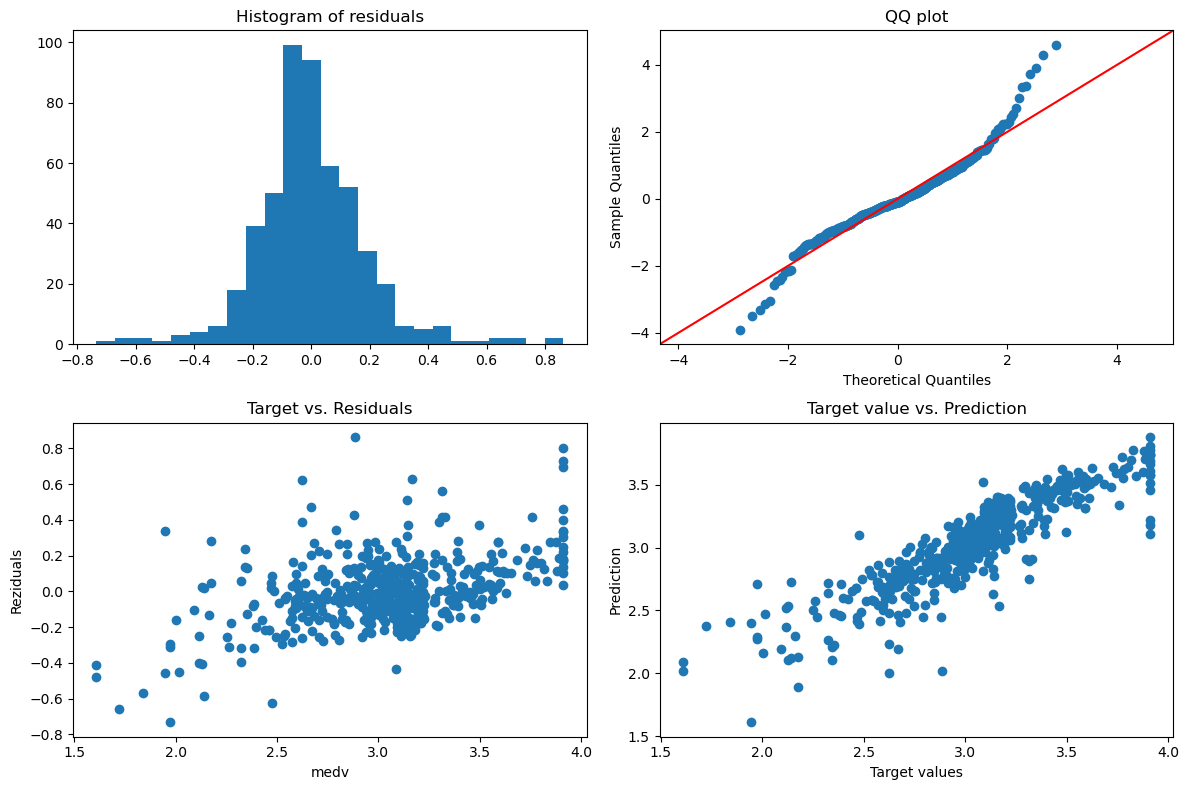

In [6]:
m3_vars = 'crim+zn+chas+nox+rm+dis+rad+tax+ptratio+black+lstat'

m3 = fml.ols(formula='np.log(medv) ~ %s' % m3_vars, data=data.data)
res3 = m3.fit()
print(res3.summary())
plot_model_evaluation(res3, np.log(data.data['medv']))

At least from the residuals point of view, the model looks a little bit better now, we can't compare the quality of both models directly from the listings, because we predict something different, but we can try to figure out what the mean square errors are for both of them. We'll see that the model predicting the logarithm of the price is a little bit better.

In [7]:
resid2 = data.data['medv']-res2.fittedvalues
err2 = np.sqrt(sum(resid2**2)/len(resid2))
resid3 = data.data['medv']-np.exp(res3.fittedvalues)
err3 = np.sqrt(sum(resid3**2)/len(resid3))

print('Model 2: %.3f' % err2)
print('Model 3: %.3f' % err3)

Model 2: 4.680
Model 3: 4.315


Let's see if we can remove any other variables from the model yet. We can figure that out, for example, by using the F-test to see what happens to the model from which we remove one variable, if it is significantly different from our original model.

In [8]:
for i in range(len(res3.params)):
    name = res3.model.exog_names[i]
    print('%s: %.5f' % (name, res3.f_test('%s = 0' % name).pvalue))

Intercept: 0.00000
crim: 0.00000
zn: 0.04531
chas: 0.00224
nox: 0.00000
rm: 0.00000
dis: 0.00000
rad: 0.00000
tax: 0.00004
ptratio: 0.00000
black: 0.00013
lstat: 0.00000


The fact that the values of the test came out the same as the p-values in the table above is not a coincidence, it will always be so. In fact, the values in the table represent exactly the result of the test after removing the given value. However, let's try to remove the variable that has the least influence and is close to the 5% significance of the test, i.e. `zn`.

                            OLS Regression Results                            
Dep. Variable:           np.log(medv)   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     183.4
Date:                Mon, 11 Nov 2024   Prob (F-statistic):          2.28e-159
Time:                        16:34:58   Log-Likelihood:                 126.96
No. Observations:                 506   AIC:                            -231.9
Df Residuals:                     495   BIC:                            -185.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1001      0.204     20.148      0.0

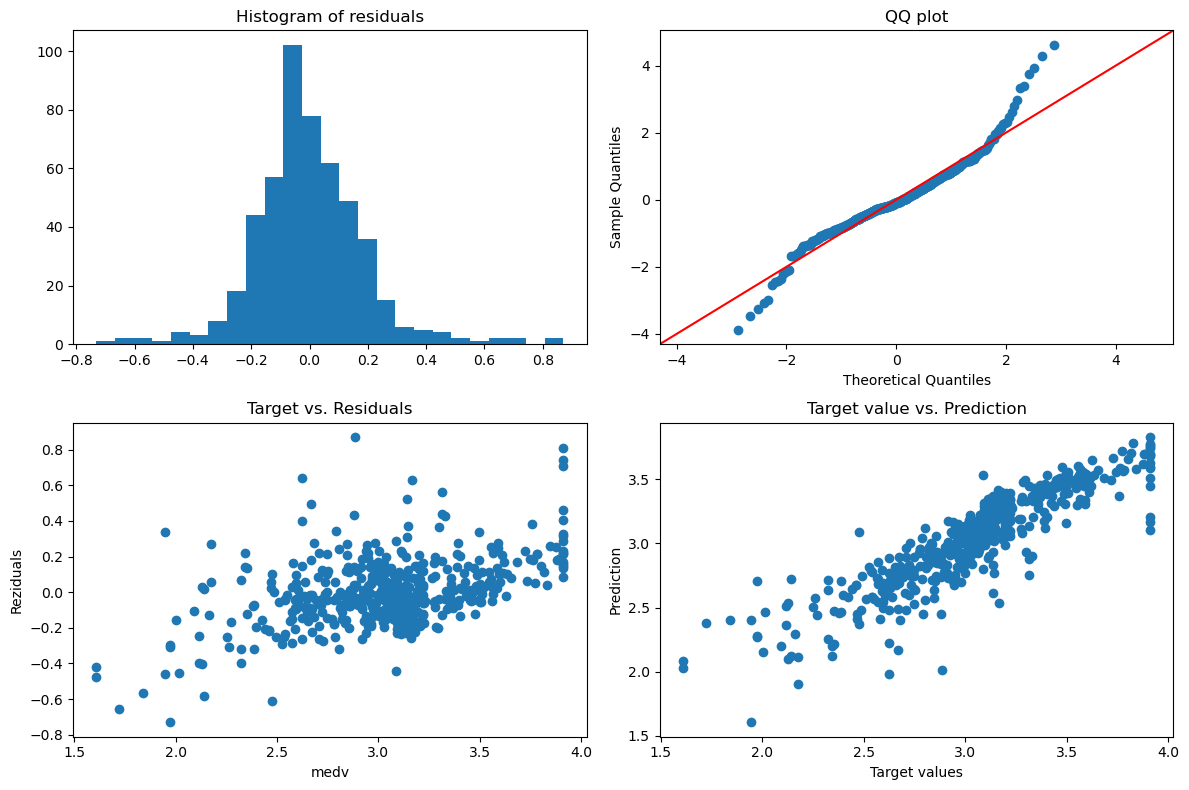

In [9]:
m4_vars = 'crim+chas+nox+rm+dis+rad+tax+ptratio+black+lstat'

m4 = fml.ols(formula='np.log(medv) ~ %s' % m4_vars, data=data.data)
res4 = m4.fit()
print(res4.summary())
plot_model_evaluation(res4, np.log(data.data['medv']))

The change in the quality of the model seems minimal, but the model is a bit simpler, so it can generalize better. We actually showed the first step of one of the variable selection algorithms. If we wanted to reduce the number of variables even further, it would be natural to remove the variable with the smallest influence again, i.e. in this case `chas`.

There are more procedures for selecting variables in linear regression, of course we can try all subsets of a set of variables (this can be done for sets up to about 40 variables thanks to various tricks), or we can start (as above) with a model of all variables and remove the least important ones, or, alternatively, start with a constant model and add the variables that improve the model the most. Another option is also to start with a constant model and add the variables that have the greatest correlation with the residues of the previous model.

## Regularization

Another option to improve the quality of the model is regularization, i.e. penalizing models that have large coefficient values. This forces the model to give lower values to coefficients that are not important. Ideally, we would like such coefficients to be given a value equal to 0.

### Ridge regression a lasso regression

A frequently used method of regularization is called ridge regression. For this, instead of RSS, the value of $$ \mathrm{RSS} + \lambda\sum_{i=1}^p\beta_i^2 $$ is optimized. The $\lambda$ parameter can be used to set the ratio between regularization and RSS minimization. For larger values of $\lambda$, more emphasis is placed on regularization. Notice that the regularization term is missing $\beta_0$. Interestingly, if we run the derivation of the $\hat{\beta}$ estimate for regression but insert the formula for ridge regression, we get a very similar equation $\hat{\beta}=(X^TX + \lambda I)^{-1}X^Ty.$ By adding a positive number to the diagonal of the $X^TX$ matrix, we ensure that the matrix will always be regular (this may not have been the case with normal regression) and thus the calculated solution will be unique. This was originally the main motivation for ridge regression.

At first glance a very similar method is lasso regression, which differs from ridge regression only in that instead of the square it has an absolute value in the regularization term (it is called $L_1$ regularization, ridge regression is $L_2$). So, in lasso regression we optimize $$\mathrm{RSS} + \lambda\sum_{i=1}^p|\beta_i|.$$

Although the two methods are very similar, there is one fundamental difference between them, and that is that lasso regression can set some coefficients to 0 and thus actually performs feature selection at the same time as training. To realize why this is, we can use the following example. Let's first look at how the RSS linear model of two variables changes when we change the values of $\beta$.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.280e+05
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           1.07e-93
Time:                        16:35:02   Log-Likelihood:                 80.754
No. Observations:                  50   AIC:                            -157.5
Df Residuals:                      48   BIC:                            -153.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.5029      0.005    313.850      0.0

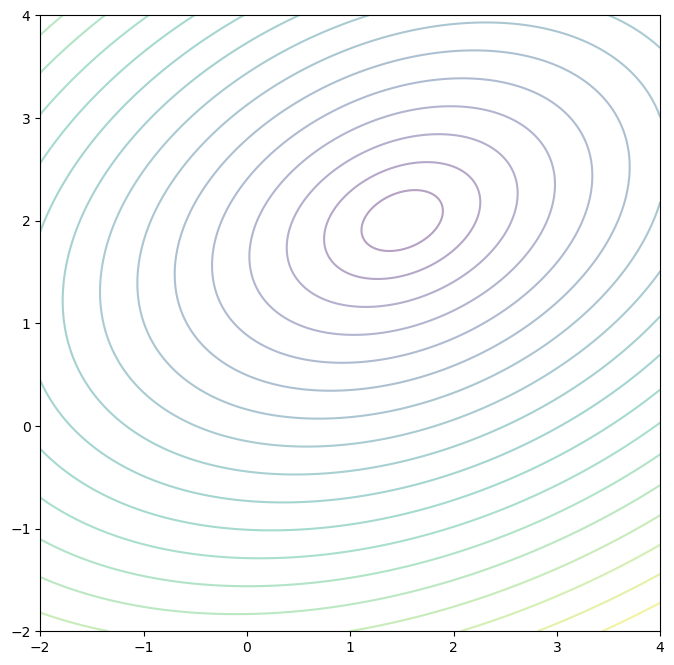

In [10]:
np.random.seed(1234)

# create a very simple data for regression (2 variables)
x = np.linspace(1, 2)
y = np.linspace(-4, 2)
z = 1.5*x+2*y+0.05*np.random.randn(len(x))

X = np.array(list(zip(x, y)))

# train a model and check how well it does
res4 = sm.OLS(z, X).fit()
print(res4.summary())

# plot the error as a function of the coefficients
def compute_error(beta, X, z):
    return np.sqrt(sum((np.dot(X, beta)-z)**2))

plt.figure(figsize=(8,8))
XX = np.linspace(-2, 4, 500)
YY = np.linspace(-2, 4, 500)
XXX, YYY = np.meshgrid(XX, YY)
betas = np.array([XXX.ravel(), YYY.ravel()]).T 
Z = np.array(list(map(lambda x: compute_error(x, X, z), betas)))
Z = Z.reshape(XXX.shape)

plt.contour(XXX, YYY, Z, levels=np.linspace(np.min(Z), np.max(Z), 20), alpha=0.4)
plt.show()

The fact that the contour plot of the loss looks like ellipses is not a coincidence, of course, RSS is a quadratic function of the variables $\beta$. But what does this mean for the difference between ridge and lasso regression? The problem of ridge regression can be rewritten as RSS minimization under the condition $\sum_{i=1}^p\beta_i^2\leq t$ for some $t$. Similarly, the optimization of lasso regression can be rewritten as RSS minimization under the condition $\sum_{i=1}^p|\beta_i|\leq t$ for some $t$. So what do the areas look like where we look for a minimum relative to the values of $\beta$? For ridge regression it is a circle with a radius of $\sqrt{t}$ for lasso regression it is a square with vertices on the axes of the graph in points $[\pm t, 0]$ and $[0, \pm t]$. It is the sharp corners in the case of lasso regression that lead to the fact that the minimum is more likely to occur exactly where one or more of the parameters $\beta$ is zero. In higher dimensions the formations look similar, in the case of lasso regression the sharp edges are much more common and the chance of one of the parameters being exactly zero is0 increasing.

Of course, theoretically we can generalize both ridge regression and lasso regression and use in general $L_p$ regularization, for $p$ between 0 and 1 we get a non-convex area, which makes optimization more difficult, but increases the probability that some of the parameters will be exactly 0.

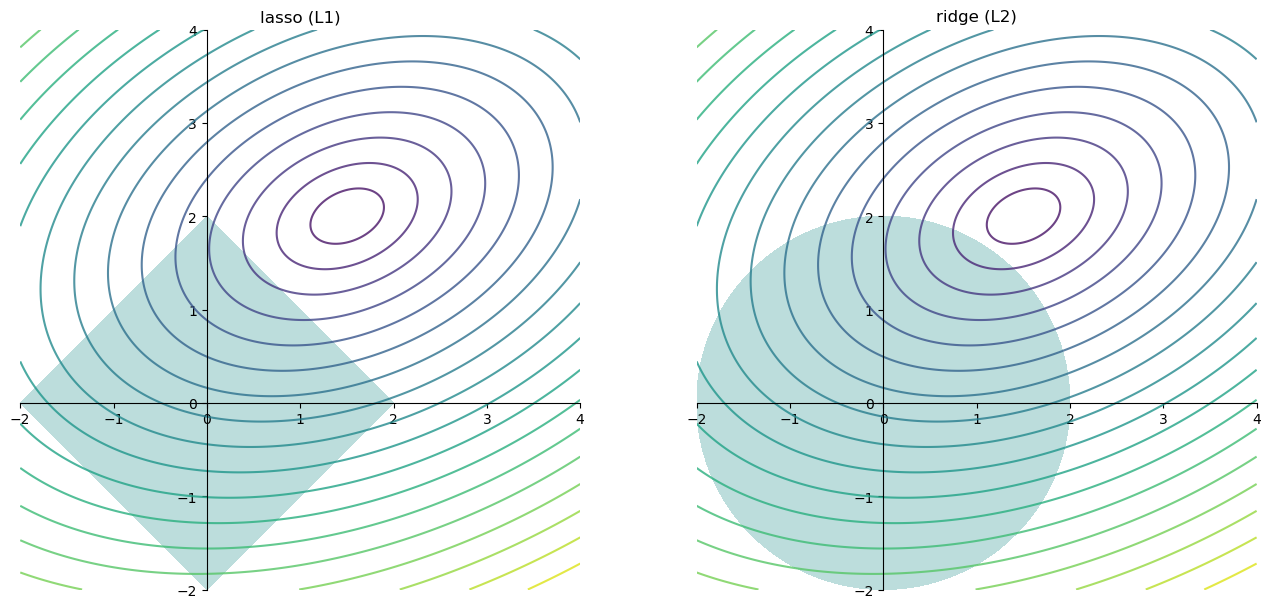

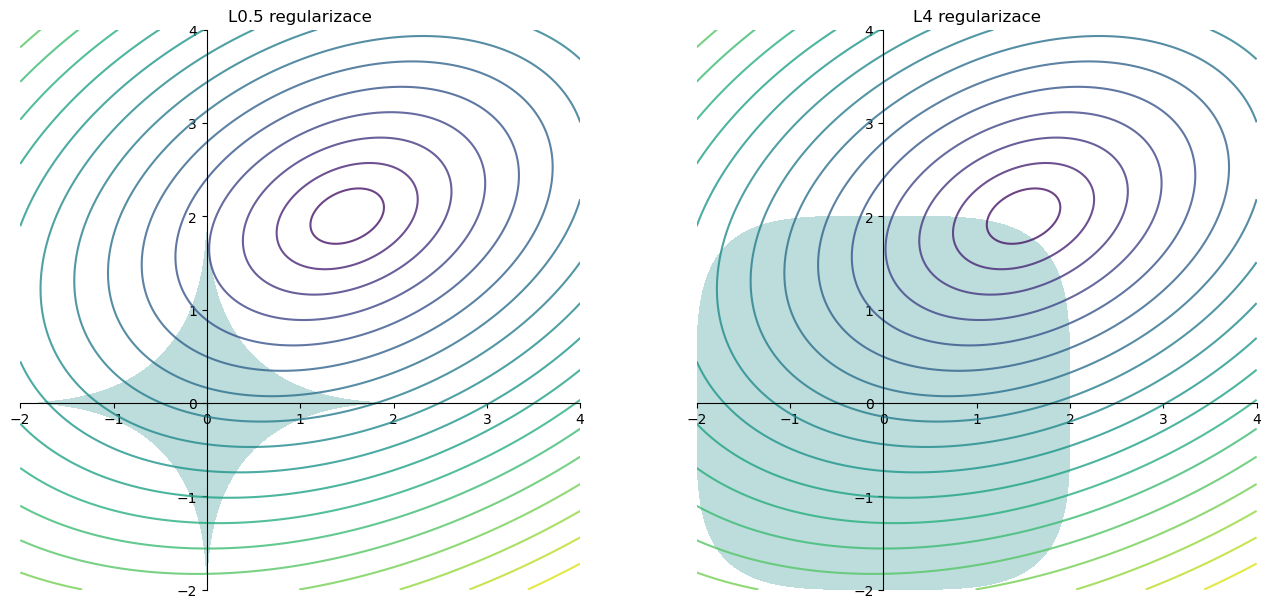

In [18]:
# regularization terms, the constants are set up so that the areas touch the axis at -2 and 2
Z_lasso = np.abs(betas[:,0])+np.abs(betas[:,1]) - 2
Z_ridge = betas[:, 0]**2 + betas[:, 1]**2 - 4
Z_L05 = np.abs(betas[:, 0])**0.5 + np.abs(betas[:, 1])**0.5 - np.sqrt(2)
Z_L4 = betas[:, 0]**4 + betas[:, 1]**4 - 16

plt.figure(figsize=(16, 16))
ax = plt.subplot(2,2,1)
ax.contour(XXX, YYY, Z, levels=np.linspace(np.min(Z), np.max(Z), 20), alpha=0.8)
ax.contourf(XXX, YYY, Z_lasso.reshape(XXX.shape), levels=[-1000, 0], alpha=0.3)
ax.set_aspect(1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title('lasso (L1)')

ax = plt.subplot(2,2,2)
ax.contour(XXX, YYY, Z, levels=np.linspace(np.min(Z), np.max(Z), 20), alpha=0.8)
ax.contourf(XXX, YYY, Z_ridge.reshape(XXX.shape), levels=[-1000, 0], alpha=0.3)
ax.set_aspect(1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title('ridge (L2)')

plt.figure(figsize=(16, 16))
ax = plt.subplot(2,2,1)
ax.contour(XXX, YYY, Z, levels=np.linspace(np.min(Z), np.max(Z), 20), alpha=0.8)
ax.contourf(XXX, YYY, Z_L05.reshape(XXX.shape), levels=[-1000, 0], alpha=0.3)
ax.set_aspect(1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title('L0.5 regularizace')

ax = plt.subplot(2,2,2)
ax.contour(XXX, YYY, Z, levels=np.linspace(np.min(Z), np.max(Z), 20), alpha=0.8)
ax.contourf(XXX, YYY, Z_L4.reshape(XXX.shape), levels=[-1000, 0], alpha=0.3)
ax.set_aspect(1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title('L4 regularizace')

plt.show()

What will be the result of the ridge regression and lasso regression on our data? We will again predict the logarithm of the price. For ridge and lasso regression we have to use scikit-learn, statsmodels don't seem to support it. Let's also plot how the parameter values change depending on the value of the regularization parameter.

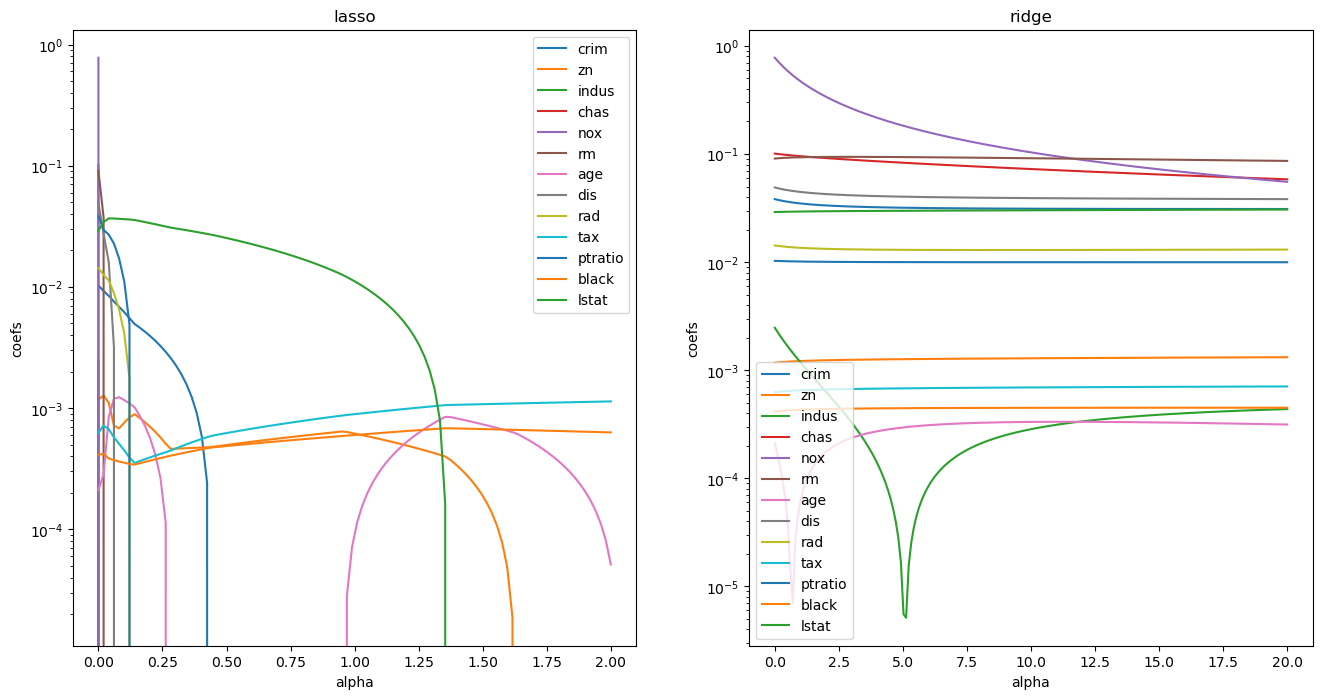

In [19]:
from sklearn import linear_model
import pandas as pd

train_y = np.log(data.data['medv'])
train_X = data.data.drop('medv', axis=1)

alphas = np.linspace(0, 2, 100)+0.000001
coefs_lasso = pd.DataFrame(columns=train_X.columns, index=alphas)
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(train_X, train_y)
    coefs_lasso.loc[alpha] = np.abs(lasso.coef_)    

alphas = np.linspace(0, 20, 200)+0.000001
coefs_ridge = pd.DataFrame(columns=train_X.columns, index=alphas)
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha)
    ridge.fit(train_X, train_y)
    coefs_ridge.loc[alpha] = np.abs(ridge.coef_)
    
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,2,1)
coefs_lasso.plot(ax=ax)
ax.set_yscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coefs')
ax.set_title('lasso')

ax = plt.subplot(1,2,2)
coefs_ridge.plot(ax=ax)
ax.set_yscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coefs')
ax.set_title('ridge')
plt.show()

### Elastic net

An interesting trade-off between lasso regression and ridge regression is elastic net regression, which combines both approaches by adding up both regularization terms. Thus, it minimizes $$\mathrm{RSS}+\lambda_1\sum_{i=1}^p|\beta_i| + \lambda_2\sum_{i=1}^p\beta_i^2 .$$ This method retains the sharp edges of lasso and also contains convex parts from ridge regression.

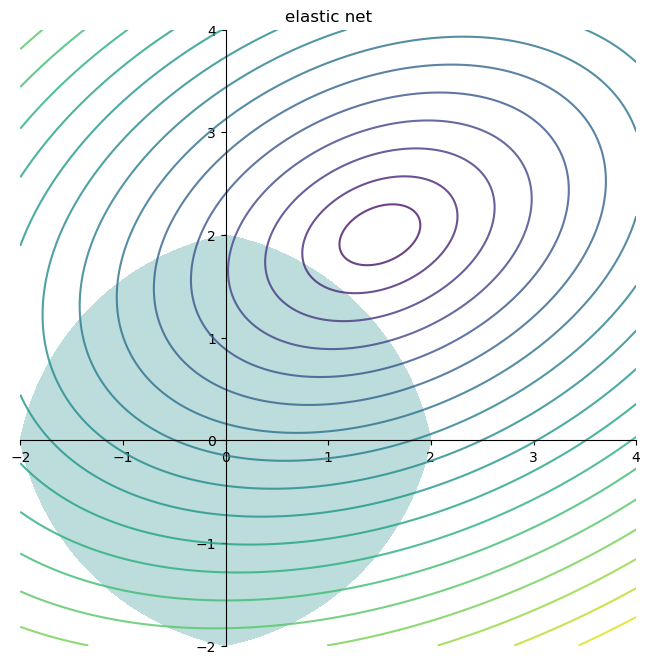

In [21]:
Z_elastic_net = np.abs(betas[:,0])+np.abs(betas[:,1]) +betas[:,0]**2 + betas[:, 1]**2 - 6

plt.figure(figsize=(8, 8))
ax = plt.subplot(1,1,1)
ax.contour(XXX, YYY, Z, levels=np.linspace(np.min(Z), np.max(Z), 20), alpha=0.8)
ax.contourf(XXX, YYY, Z_elastic_net.reshape(XXX.shape), levels=[-1000, 0], alpha=0.3)
ax.set_aspect(1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_title('elastic net')
plt.show()